In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn

## Simple diagnostic diagram

In the following cell, we will write a file that contains observed data on the disk 

In [2]:
%%writefile smc24.dat
NAME SMC_24
cHbeta     0.047
S4_10.5m   7.00000
Ne2_12.8m  8.3000
Ne3_15.6m 34.10
S3_18.7m  10.
O2_3726A  39.700
O2_3729A  18.600
Ne3_3869A 18.90
Ne3_3968A  6.4
S2_4069A   0.85
S2_4076A   0.450
O3_4363A   4.36
O3_5007A 435.09
N2_5755A   0.510000
S3_6312A   0.76
O1_6300A   1.69
O1_6364A   0.54
N2_6548A   6.840000
N2_6584A  19.00
S2_6716A   1.220000
S2_6731A   2.180000
Ar3_7136A  4.91
O2_7319A+   6.540000
O2_7330A+   5.17
S3_33.6m    8.

Writing smc24.dat


warng EmissionLine: line 33.6m for atom S3 not valid


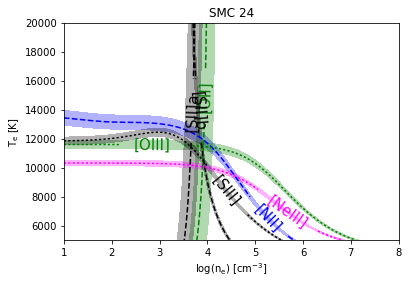

Te = 12071 K, Ne =  4619.6 cm-1


In [6]:
# Diagnostic plot

### General settings
# Setting verbosity level. Enter pn.my_logging? for details
pn.log_.level = 2 # set this to 3 to have more details

# Adopt an extinction law
extinction_law = 'CCM89'

# Define the data file
obs_data = 'smc24.dat'

# Define plot title
title = 'SMC 24'

### Read and deredden observational data
# define an Observation object and assign it to name 'obs'
obs = pn.Observation()

# fill obs with data read from file obs_data, with lines varying across rows and a default percent error on line intensities
obs.readData(obs_data, fileFormat='lines_in_rows', err_default=0.05)

# deredden data with Cardelli's law
obs.extinction.law = extinction_law
obs.correctData()

### Include the diagnostics of interest
# instantiate the Diagnostics class
diags = pn.Diagnostics()
# include in diags the relevant line ratios
diags.addDiag([
              '[NII] 5755/6584', 
              '[OII] 3726/3729', 
              '[OIII] 4363/5007', 
              '[SII] 6731/6716', 
              '[SII] 4072+/6720+',
              '[SIII] 6312/18.7m', 
              '[NeIII] 3930+/15.6m', 
              ])
diags.addClabel('[SII] 6731/6716', '[SII]a')
diags.addClabel('[SII] 4072+/6720+', '[SII]b')

# Create the emission maps to be compared to the observation data (some overkill here)
emisgrids = pn.getEmisGridDict(atom_list=diags.getUniqueAtoms(), den_max=1e6)

### Plot
# Create the contour plot as the intersection of tem-den emission maps with dereddened line ratios
diags.plot(emisgrids, obs)

# Place the title
plt.title(title)

# Display the plot
plt.show()

#The observed ratio can be automatically extracted from an Observation object named obs:
Te, Ne = diags.getCrossTemDen('[NII] 5755/6548', '[SII] 6731/6716', obs=obs)
print('Te = {0:5.0f} K, Ne = {1:7.1f} cm-1'.format(Te, Ne))

## Extinction

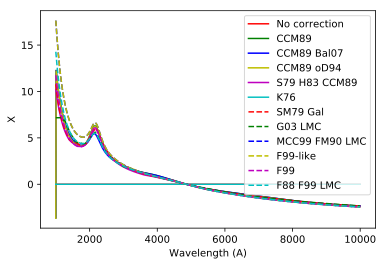

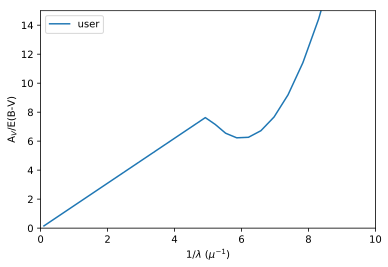

Correction based on the given law and the observed Ha/Hb ratio:
5007: I_obs = 4.0  I_dered = 3.89887770727
4686: I_obs = 0.1  I_dered = 0.103424700345

Correction based on the given law and c(Hbeta):
5007: I_obs = 4.0  I_dered = 3.89706278973
4686: I_obs = 0.1  I_dered = 0.103488047966


In [8]:
# Sample extinction in PyNeb
# shows how to display available extinction laws, select one or define a new one,
# and do some simple dereddening calculations
# Further examples can be found in other sample scripts
%config InlineBackend.figure_format = 'svg'

# Convert wavelength to x
def x(wave):
    return 10000. / wave

# Define an extinction law (to be used below)
def my_X(wave, par=0):
    x = 10000. / wave
    Rv = 3.1
    X_lin = x/2. # linear part of the extinction law
    X_bump = 0.5*x**2. -6*x + 20. # bump part of the extinction law
    return Rv*np.where(x<5., X_lin, X_bump)

# Define a reddening correction object
RC = pn.RedCorr()

# List the available laws
#RC.printLaws()

# Plot the available laws
plt.figure(figsize=(10,10))
RC.plot(laws='all')
plt.show()

# Choose the one we intend to use 
RC.law = 'CCM89'
# or define a new one
RC.UserFunction = my_X
RC.law = 'user'

# Plot the selected law as a function of x
# Define an array in lambda to do the plot
wave= np.logspace(2.5, 5, 100)
# Plot commands
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0, 15])
ax.set_xlim([0, 10])
ax.plot(x(wave), my_X(wave), label='%s' % (RC.law))
plt.xlabel('1/$\lambda$ ($\mu^{-1}$)')
plt.ylabel('A$_V$/E(B-V)')
plt.legend(loc='upper left')
plt.show()

# Correct observed line ratios
wave1 = 5007
I_obs1 = 4.0
wave2 = 4686
I_obs2 = 0.10

# Correct based on the given law and the observed Ha/Hb ratio
RC = pn.RedCorr(law='CCM89')
I_obs_HaHb = 3.5 
I_theo_HaHb = 2.86 
RC.setCorr(I_obs_HaHb / I_theo_HaHb, 6563., 4861.)
print('Correction based on the given law and the observed Ha/Hb ratio:')
print(str(wave1) + ': I_obs =', I_obs1, ' I_dered =', I_obs1 * RC.getCorrHb(wave1))
print(str(wave2) + ': I_obs =', I_obs2, ' I_dered =', I_obs2 * RC.getCorrHb(wave2))

# Correct based on the given law and c(Hb)
RC = pn.RedCorr(law='CCM89', cHbeta=0.3)
print('\nCorrection based on the given law and c(Hbeta):')
print(str(wave1) + ': I_obs =', I_obs1, ' I_dered =', I_obs1 * RC.getCorrHb(wave1))
print(str(wave2) + ': I_obs =', I_obs2, ' I_dered =', I_obs2 * RC.getCorrHb(wave2))


## Line ratio and diagnostics

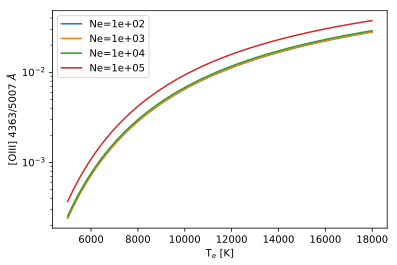

In [12]:
"""
Sample PyNeb script
Plots the [O III] 4363/5007 ratio as a function of Te for several Ne values
"""

# Set high verbosity level to keep track of atom creation
pn.log_.level = 1 # Set to 3 if you want all the atoms to be printed out

# Create a collection of atoms - a bit overkill if we just need O III
adict = pn.getAtomDict()

# Lower verbosity level
pn.log_.level = 2

# Function to compute line ratio
def line_ratio(atom, wave1, wave2, tem, den):
    emis1 = adict[atom].getEmissivity(tem, den, wave = wave1)
    emis2 = adict[atom].getEmissivity(tem, den, wave = wave2)
    return emis1 / emis2

# Define array of Te 
tem = np.arange(5000, 18000, 30)

# Plot
plt.figure(1)
for den in [1e2, 1e3, 1e4, 1e5]:
    plt.semilogy(tem, line_ratio('O3', 4363, 5007, tem, den), label = 'Ne={0:.0e}'.format(den))
plt.xlabel('T$_e$ [K]')
plt.ylabel(r'[OIII] 4363/5007 $\AA$')
plt.legend(loc=2)

plt.show()

## Contour plots

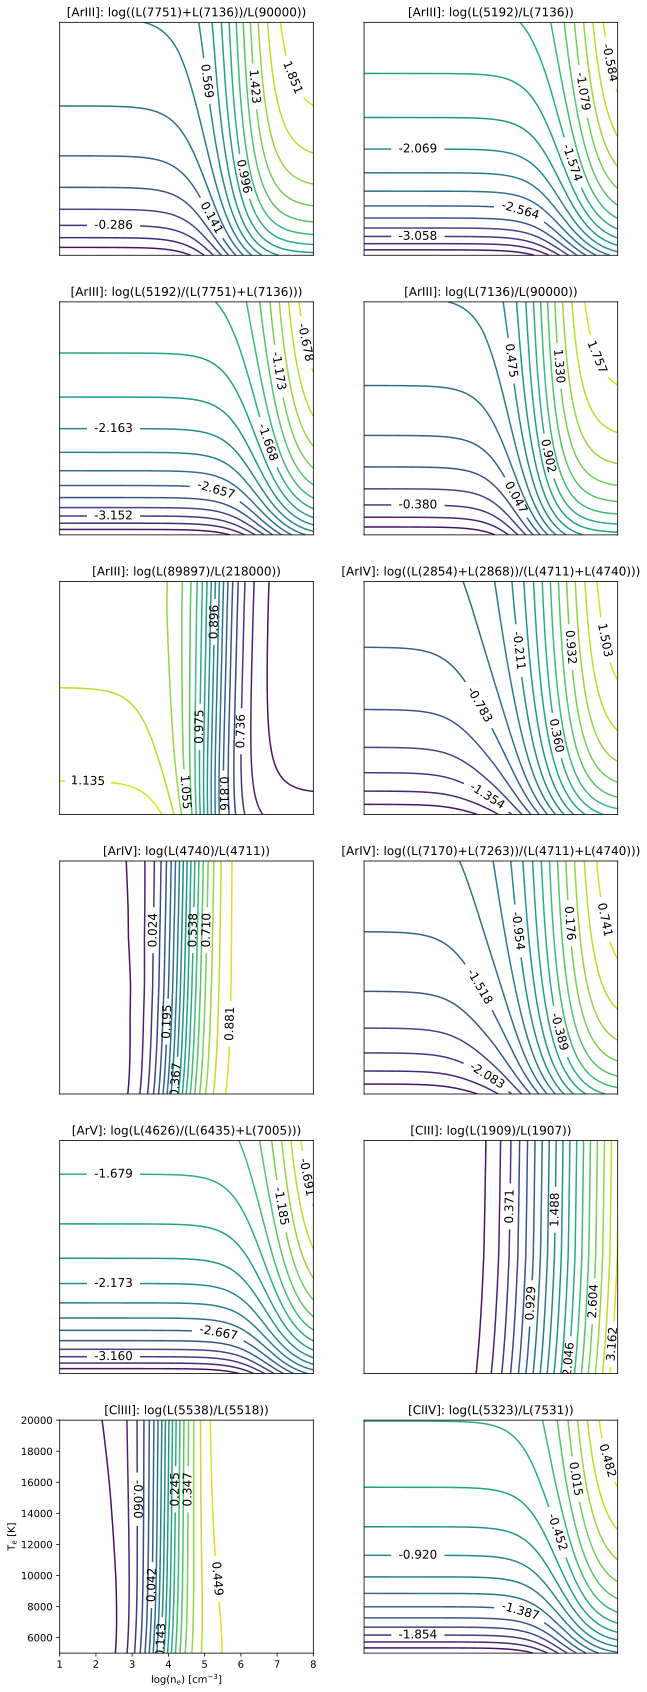

In [14]:
# Plot the contour diagram of the selected diagnostics
# Warning: it takes a long time to plot the 80 contours
from pyneb.core.diags import diags_dict

Nx = 2 
Ny = 6 # must be changed to 30 to obtain all the plots
pn.log_.level=1
AA = pn.getAtomDict(OmegaInterp='Linear')
    # Loop over all the diags stored in pn.core.diags.diags_dict
fig, axes = plt.subplots(Ny, Nx, figsize=(5*Nx, 5*Ny))
i_ax = 0
for diag in np.sort(list(diags_dict.keys())):
    atom, diag_eval, err = diags_dict[diag]
    # Skip Fe III as they are so many
    if (atom in AA) and (atom != 'Fe3'):
        if i_ax < Nx*Ny:
            ax = axes.ravel()[i_ax]
            grid = pn.EmisGrid(atomObj=AA[atom])
            grid.plotContours(to_eval=diag_eval, ax=ax)
            if i_ax != (Nx * (Ny-1)):
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            i_ax += 1
plt.show()

## Diagnostic diagrams of a 2-components region

warng EmissionLine: line 6.4m for atom Ar3 not valid
warng EmissionLine: line 1.0m for atom S2 not valid
ERROR Atom O3: The number of levels 5 does not allow getting this emissivity (6-1). Consider changing the atomic data
ERROR Atom O3: The number of levels 5 does not allow getting this emissivity (6-2). Consider changing the atomic data
ERROR Atom O3: The number of levels 5 does not allow getting this emissivity (6-3). Consider changing the atomic data
ERROR Atom O3: The number of levels 5 does not allow getting this emissivity (6-4). Consider changing the atomic data
ERROR Atom O3: The number of levels 5 does not allow getting this emissivity (6-5). Consider changing the atomic data
ERROR Atom O2: The number of levels 5 does not allow getting this emissivity (6-1). Consider changing the atomic data
ERROR Atom O2: The number of levels 5 does not allow getting this emissivity (6-2). Consider changing the atomic data
ERROR Atom O2: The number of levels 5 does not allow getting this emi

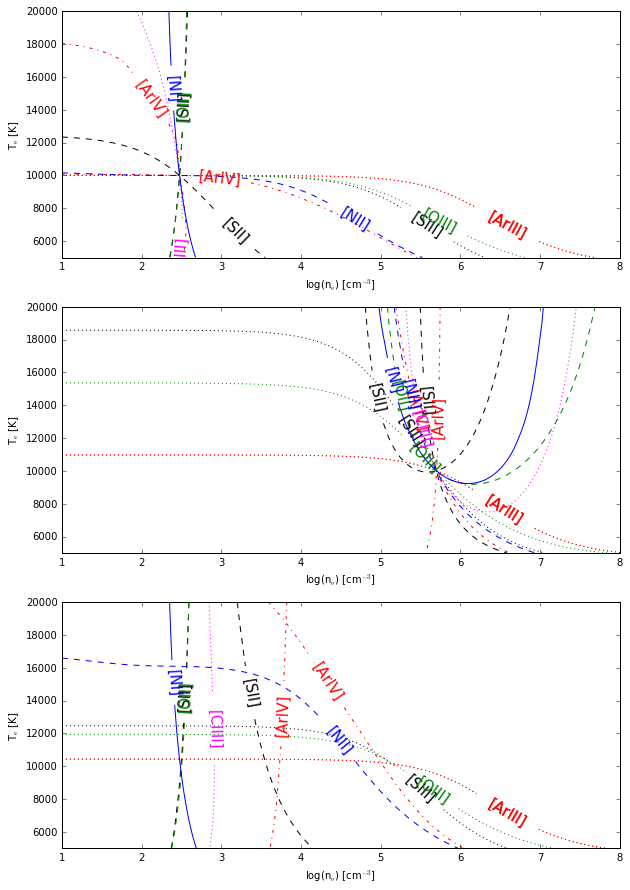

In [3]:
# Analysis plot of a simple two-component model, meant to illustrate the bias arising 
# from assuming that the region is homogeneous in density
# First, an emission region made up of two different subregions is modelled,
# each with a different mass and density. The resulting overall emissivity is computed
# Second, the region is analyzed as if it were a homogeneous region

from pyneb.utils.misc import parseAtom

def plot_2comp(tem1=1e4, tem2=1e4, dens1=3e2, dens2=5e5, mass1=1, mass2=5e-4):
        
    # List of diagnostics used to analyze the region
    diags = pn.Diagnostics()
    
    diags.addDiag(['[NI] 5198/5200',
                   '[NII] 5755/6548',
                    '[OII] 3726/3729',
                    '[OII] 3727+/7325+',
                    '[OIII] 4363/5007', 
                    '[ArIII] 5192/7136',
                    '[ArIII] 5192/7300+',
                    '[ArIV] 4740/4711',
                    '[ArIV] 7230+/4720+',
                    '[SII] 6731/6716', 
                    '[SII] 4072+/6720+',
                    '[SIII] 6312/9069',
                    '[ClIII] 5538/5518'
                    ])
    """    
    for diag in pn.diags_dict:
        if diag[0:7] != '[FeIII]':
            diags.addDiag(diag)
            print 'Adding', diag
            
    diags.addClabel('[SIII] 6312/9069', '[SIII]A')
    diags.addClabel('[OIII] 4363/5007', '[OIII]A')
    """    
    # Define all the ions that are involved in the diagnostics
    adict = diags.atomDict
    pn.log_.message('Atoms built')
    
    obs = pn.Observation(corrected = True)
    for atom in adict:
        # Computes all the intensities of all the lines of all the ions considered
         for line in pn.LINE_LABEL_LIST[atom]:
            if line[-1] == 'm':
                wavelength = float(line[:-1])*1e4
            else:
                wavelength = float(line[:-1])
            elem, spec = parseAtom(atom)
            try:
                intens1 = adict[atom].getEmissivity(tem1, dens1, wave = wavelength) * dens1 * mass1
                intens2 = adict[atom].getEmissivity(tem2, dens2, wave = wavelength) * dens2 * mass2
                obs.addLine(pn.EmissionLine(elem, spec, wavelength,
                                         obsIntens=[intens1, intens2, intens1+intens2], 
                                         obsError=[0.0, 0.0, 0.0]))
            except:
                pass
    pn.log_.message('Virtual observations computed')
    emisgrids = pn.getEmisGridDict(atomDict=adict)
    
    pn.log_.message('EmisGrids available')
    
    # Produce a diagnostic plot for each of the two regions and another one for the 
    # (misanalyzed) overall region
    f, axes = plt.subplots(3,1, figsize=(10,15))
    for i_obs in (0,1,2):
        diags.plot(emisgrids, obs, i_obs=i_obs, ax=axes[i_obs])

plot_2comp(tem1=1e4, tem2=1e4, dens1=3e2, dens2=5e5, mass1=1, mass2=5e-4)
plt.show()

## Plot emissivities

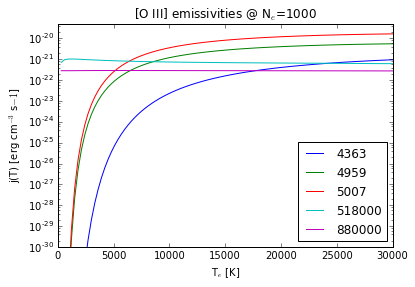

In [4]:
# Emissivity plot
# For a quick and dirty plot, see also o3.plotEmiss

# Atom creation and definition of physical conditions 
o3=pn.Atom('O', 3)
tem=np.arange(100)*300+300
den = 1000

# Comment the second if you want all the lines to be plotted
lineList=o3.lineList
lineList=[4363, 4959, 5007, 518000, 880000]

# Plot	
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([1.e-30, 5e-20])

for line in lineList:
    y=o3.getEmissivity(tem, den, wave=line)
    plt.semilogy(tem, y,  label="{:.0f}".format(line))

plt.xlabel('T$_e$ [K]')
plt.ylabel("j(T) [erg cm$^{-3}$ s${-1}$]")
plt.legend(loc='lower right')
plt.title('[O III] emissivities @ N$_e$={:.0f}'.format(den))
plt.show()

## Emissivity map of a line

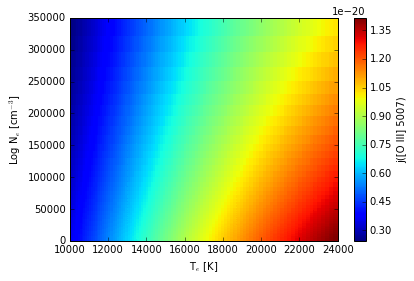

In [6]:
# Emissivity map of [O III] 5007 

# Imports
import pyneb as pn
import matplotlib.pyplot as plt

# Compute the grid 
map=pn.EmisGrid('O', 3, tem_min=10000, tem_max=23999.00, den_min=100, den_max=3.5e5, n_tem=100, n_den=100)
X=map.tem2D
Y=map.den2D
Z=map.getGrid(wave=5007)

# Plot
emap = plt.pcolor(X, Y, Z)
cbar = plt.colorbar(emap)
cbar.set_label('j([O III] 5007)')
plt.xlabel(r'T$_e$ [K]')
plt.ylabel(r'Log N$_e$ [cm$^{-3}$]')
plt.show()

## Emissivity map of a line ratio

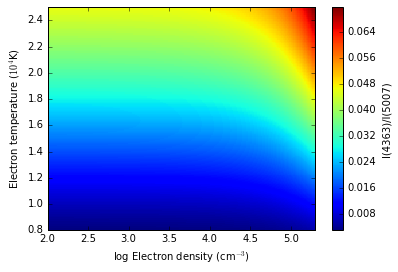

In [7]:
# Emissivity map of the [O III] 4363/5007 line ratio

# Imports
import pyneb as pn

# Compute the grid 
o3grid = pn.EmisGrid('O', 3, n_tem=200, n_den=200, tem_min=8000, tem_max=25000, den_min=100, den_max=2.e5)

# Plot the grid
o3grid.plotImage('L(4363)/L(5007)', cblabel='I(4363)/I(5007)');